In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, FreqDist, regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import string
import re
%matplotlib inline

# Data Exploration #

In [2]:
file='movie.csv'
df=pd.read_csv(file)

In [3]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
df['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [23]:
text=df['text'].str.lower()
labels=df['label']
X_train, X_test, y_train, y_test = train_test_split(text,labels,test_size=.2,random_state=20)

In [24]:
X_train.head()

36862    ok, here it is: "nazi mountaineer befriends th...
11768    romance is in the air and love is in bloom in ...
36393    this film is described as a action/comedy. the...
12031    i love the satan pit!!! david tennant is such ...
27211    i could never stand watching happy days after ...
Name: text, dtype: object

### Tokenize ###

In [25]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

tokenizer=RegexpTokenizer(pattern)
tokenized_train=X_train.apply(tokenizer.tokenize)

In [28]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [30]:
stopwords_list=stopwords.words('english')
ns_tk_train=tokenized_train.apply(remove_stopwords)

In [26]:
tokenized_train.head()

36862    [ok, here, it, is, nazi, mountaineer, befriend...
11768    [romance, is, in, the, air, and, love, is, in,...
36393    [this, film, is, described, as, a, action, com...
12031    [i, love, the, satan, pit, david, tennant, is,...
27211    [i, could, never, stand, watching, happy, days...
Name: text, dtype: object

In [31]:
ns_tk_train.head()

36862    [ok, nazi, mountaineer, befriends, dalai, lama...
11768    [romance, air, love, bloom, victorian, era, en...
36393    [film, described, action, comedy, first, minut...
12031    [love, satan, pit, david, tennant, great, acto...
27211    [could, never, stand, watching, happy, days, c...
Name: text, dtype: object

In [39]:
new_df=pd.concat([tokenized_train,ns_tk_train,y_train],axis=1)
new_df.columns=['token','no-stop','label']

In [41]:
pos_reviews=new_df[new_df['label']==1]
neg_reviews=new_df[new_df['label']==0]

In [47]:
#Get Freq distributions for tokens w/ and w/o stopwords and compare top words
pos_freq = FreqDist(pos_reviews['token'].explode()).most_common(10)
pos_ns_freq = FreqDist(pos_reviews['no-stop'].explode()).most_common(10)
neg_freq = FreqDist(neg_reviews['token'].explode()).most_common(10)
neg_ns_freq = FreqDist(neg_reviews['no-stop'].explode()).most_common(10)
freqs=[pos_freq,pos_ns_freq,neg_freq,neg_ns_freq]

In [51]:
#total number of words in all reviews after stop words removed
fd=FreqDist(new_df['no-stop'].explode())
len(fd)

90418

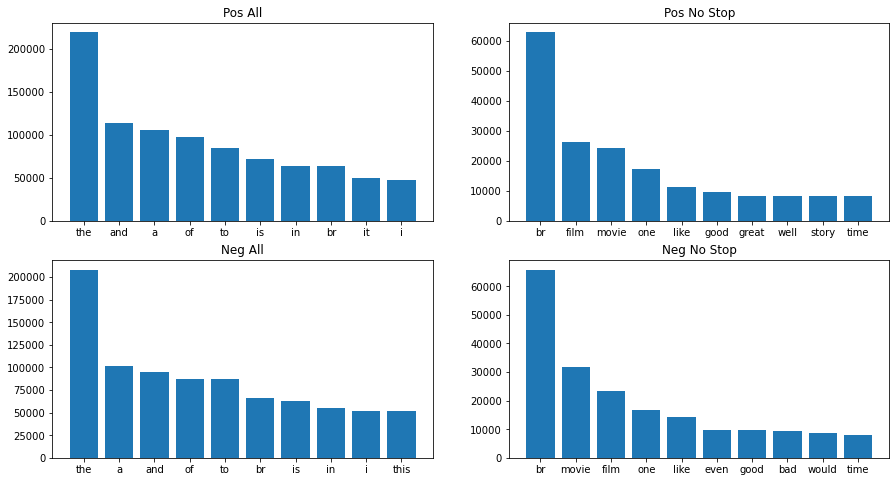

In [49]:
#Plot distributions for comparison
fig,axes=plt.subplots(2,2,figsize=(15,8))
titles=['Pos All','Pos No Stop','Neg All','Neg No Stop']

for count,ax in enumerate(axes.flatten()):
    x=[tup[0] for tup in freqs[count]]
    y=[tup[1] for tup in freqs[count]]
    ax.bar(x,y)
    ax.set_title(titles[count])


Need to investigate the token 'br'. Probably denotes a line break and shouldn't be included.

It appears that removing stop words helps differentiate between pos and neg reviews.  However, many of the top ten words are the same so we will need to train the model on a larger selection.  After removing stop words there are over 90k words in all the ratings so we will have to find a balance between reducing dimensionality and including enough training info.

In [52]:
new_df['contains_br']=new_df['no-stop'].apply(lambda x: 1 if 'br' in x else 0)
contains_br=new_df[new_df['contains_br']==1]
contains_br.head()

,token,no-stop,label,contains_br
11768,"[romance, is, in, the, air, and, love, is, in,...","[romance, air, love, bloom, victorian, era, en...",1,1
36393,"[this, film, is, described, as, a, action, com...","[film, described, action, comedy, first, minut...",0,1
14337,"[well, eyeboy, i, must, say, that, it, pleases...","[well, eyeboy, must, say, pleases, end, someon...",0,1
16003,"[what, do, you, mean, son, of, actor, not, an,...","[mean, son, actor, actor, become, actor, daddy...",1,1
2468,"[wwe's, last, ppv, of, proved, to, be, a, hit,...","[wwe's, last, ppv, proved, hit, fans, one, rea...",1,1


In [55]:
X_train.loc[11768]

"romance is in the air and love is in bloom in victorian era england, in this light-hearted story set against a society in a time in which manners were still in vogue, the ladies were charming and elegant, and the gentlemen dashing. `emma,' based on the novel by jane austen and written for the screen and directed by douglas mcgrath, stars the lovely gwyneth paltrow in the title role. a self-appointed matchmaker, emma takes great delight in the romantic notion of playing cupid and attempting to pair up those she feels are suited to one another. coming off a successful matching that ended in marriage, she next sets her sights on finding a mate for her friend, harriet (toni collette), but the outcome of her initial attempt proves to be less than satisfying. meanwhile, her endeavors are tempered by by the handsome mr. knightley (jeremy northam), whose insights into matters of the heart often seem to be a bit more astute than emma's, and lend some needed balance to the proceedings. and emma

Its clear that br is indicating line breaks. We'll remove this from all the token lists.

In [56]:
tokens_train=ns_tk_train.apply(lambda tok_list: [tok for tok in tok_list if tok!='br'])

Text(0.5, 1.0, 'negative')

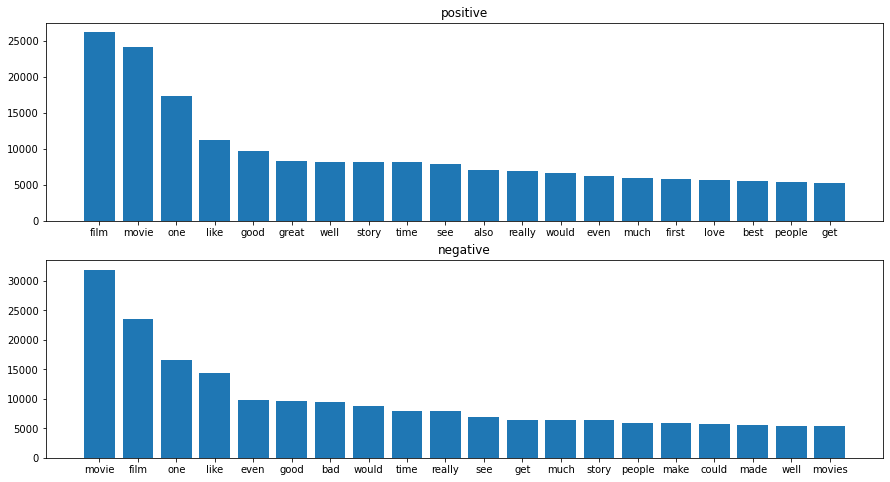

In [60]:
#redo top freq charts
tok_df=pd.concat([tokens_train,y_train],axis=1)
tok_df.columns=['token','label']
pos=tok_df[tok_df['label']==1]
neg=tok_df[tok_df['label']==0]
pos_fd=FreqDist(pos['token'].explode()).most_common(20)
neg_fd=FreqDist(neg['token'].explode()).most_common(20)

fig,axes=plt.subplots(2,figsize=(15,8))

pos_x=[tup[0] for tup in pos_fd]
pos_y=[tup[1] for tup in pos_fd]
neg_x=[tup[0] for tup in neg_fd]
neg_y=[tup[1] for tup in neg_fd]

axes[0].bar(pos_x,pos_y)
axes[0].set_title('positive')
axes[1].bar(neg_x,neg_y)
axes[1].set_title('negative')

There is not a huge difference between the top 20 words in the corpus. We'll use more for the model, but this could also indicate the importance of using bigrams to indicate how words are used together or using sequences.

# Baseline Model w/ CountVector#

In [68]:
#Create a train and validation set
train_X, val_X, train_y, val_y = train_test_split(X_train,
                                                  y_train,
                                                  test_size=.2,
                                                  random_state=40)

CountVectorizer will be used on original text with the desired characteristics outlined in the data exploration above in order to get the model features.

In [70]:
stopwords_list.append('br')

In [76]:
vectorizer=CountVectorizer(stop_words=stopwords_list,max_features=100)
tokens_train=vectorizer.fit_transform(train_X)

In [80]:
tok_train_df=pd.DataFrame.sparse.from_spmatrix(tokens_train)

In [87]:
tokens_train=tokens_train.todense()

In [90]:
tokens_train=tokens_train.toarray()

AttributeError: 'matrix' object has no attribute 'toarray'

In [88]:
type(tokens_train)

numpy.matrix

In [89]:
baseline=GaussianNB()
baseline.fit(tokens_train,train_y)
print(baseline.score(tok_train_df,train_y))

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [63]:
tfidf = TfidfVectorizer(max_features=100)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train_proc)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

AttributeError: 'list' object has no attribute 'lower'